### Libraries

In [77]:
import pandas as pd
import gzip
from io import BytesIO
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from datetime import datetime

import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import gaussian_kde
import statsmodels.api as sm


pd.options.mode.chained_assignment = None

from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, RationalQuadratic, ExpSineSquared, Matern

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

### Helper Functions

In [2]:
#function to convert data and time formats and create a column that contain both values in datetime format
def converti_data_ora(row):
    data_str = str(row['Data'])
    ora_str = str(row['Ora']-1)  # -1 because the range time is from 0 to 23 so ex. hour 1 corresponds to 00:00
    data_ora_str = data_str[:4] + '-' + data_str[4:6] + '-' + data_str[6:] + ' ' + ora_str + ':00:00'
    return datetime.strptime(data_ora_str, '%Y-%m-%d %H:%M:%S')


# Polynomial smoothing
def smooth_series(series, degree=2):
    y = series.values
    mask = ~np.isnan(y)
    coefs = Polynomial.fit(x[mask], y[mask], deg=degree)
    return coefs(x)

# LOESS smoothing 
def apply_loess(series, frac=0.3):
    lowess = sm.nonparametric.lowess # LOESS smoothing
    smoothed_values = lowess(series, series.index, frac=frac, return_sorted=False) # The series index is numeric and represents hours
    return smoothed_values

#### Reading the Data in

In [3]:
path = r'C:\Users\bartama\Desktop\PoliMi Stuff\Applied Statistics\Data\dataa\\'
file = 'ts_df.pkl.gz'

In [4]:
with gzip.open(path+file, 'rb') as f:
    loaded_df = pd.read_pickle(f)

### Filter df

In [5]:
# Getting 2023 Values

loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d')
loaded_df = loaded_df.loc[loaded_df['Data'].dt.year == 2023,:]

In [6]:
loaded_df = loaded_df.loc[loaded_df.ZonaMercato=='CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CORS;FRAN;GREC;SLOV;SVIZ;MALT;COUP;MONT;',:]


In [7]:
# Combine 'Data' and 'Ora' columns and convert to datetime

loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
loaded_df['Ora'] = (loaded_df['Ora'] - 1).astype(str).str.zfill(2) + ':00:00'
loaded_df['DataOra'] = pd.to_datetime(loaded_df['Data'] + ' ' + loaded_df['Ora'])

In [8]:
# rename columns to English

column_mapping = {'Data': 'Day', 'Ora': 'Hour',"Mercato":"Market", 'ZonaMercato': 'MarketArea', 'PrezzoZonale': 'ZonalPrice', 'Quantita': 'Quantity', 'Prezzo': 'Price', 'Tipo': 'Type', "DataOra": "Date"}

loaded_df.rename(columns=column_mapping, inplace=True)

### Preprocess

In [9]:
#loaded_df[['ZonalPrice', 'MarketArea']].drop_duplicates()
columns_wanted = ['Date', 'ZonalPrice', 'Quantity','Price']

In [10]:
bid = loaded_df.loc[loaded_df.Type == "BID",columns_wanted]

bid_df = bid.copy()
bid.Price = bid.Price *-1 ## for bid prices, take the negative of it
bid = bid.sort_values(by=['Price']).reset_index(drop = True) # sort in ascending way
bid['Cumulative Quantity'] = bid.Quantity.cumsum()

ask = loaded_df.loc[loaded_df.Type == "OFF",columns_wanted]
ask_df = ask.copy()
ask = ask.sort_values(by=['Price']).reset_index(drop = True)
ask['Cumulative Quantity'] = ask.Quantity.cumsum()


## PLOTTIN FOR INITIAL OVERVIEW

#### BID

KeyboardInterrupt: 

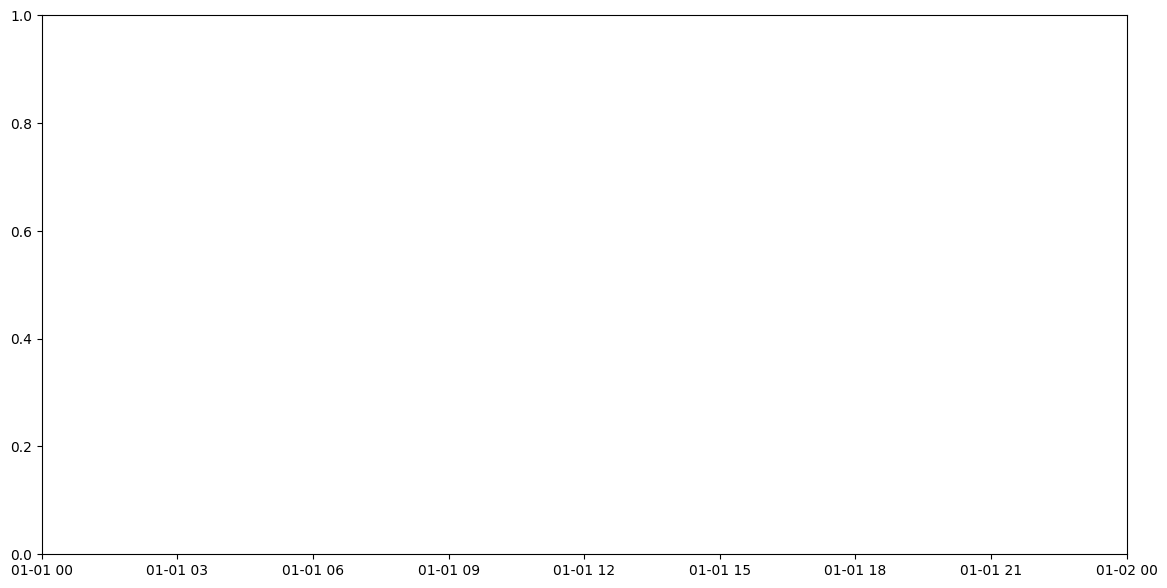

In [14]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='ZonalPrice', data=bid_df)
plt.title('Zonal Price Trend over Time')
plt.show()

In [24]:
# Extract hours and days of the week
bid_df['hour'] = bid_df['Date'].dt.hour
bid_df['day_week'] = bid_df['Date'].dt.dayofweek


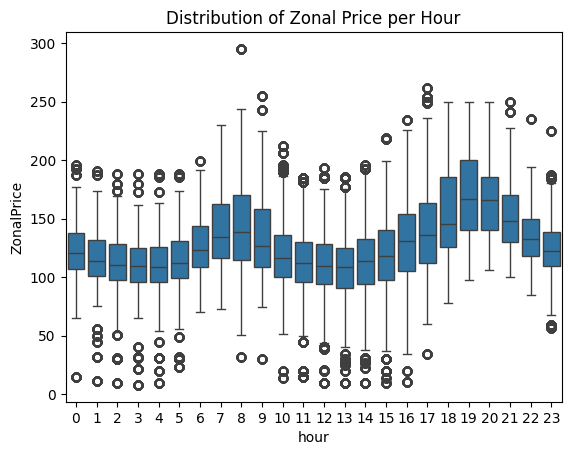

In [25]:
# Analysis for hours
sns.boxplot(x='hour', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price per Hour')
plt.show()

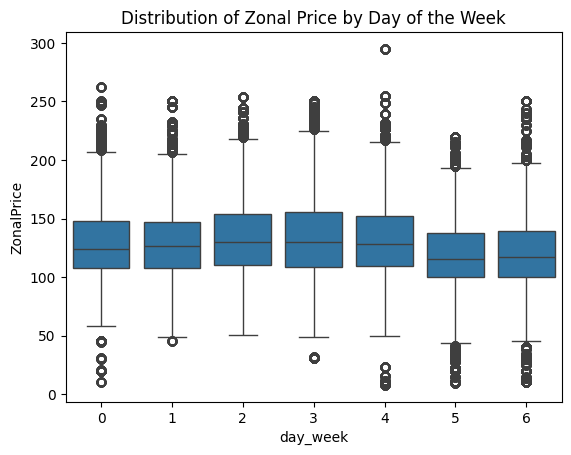

In [26]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price by Day of the Week')
plt.show()

#### ASK

In [27]:
# Extract hours and days of the week
ask_df['hour'] = ask_df['Date'].dt.hour
ask_df['day_week'] = ask_df['Date'].dt.dayofweek


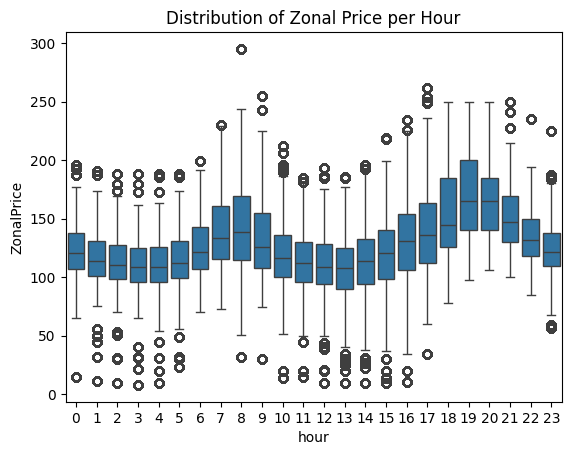

In [28]:
# Analysis for hours
sns.boxplot(x='hour', y='ZonalPrice', data=ask_df)
plt.title('Distribution of Zonal Price per Hour')
plt.show()

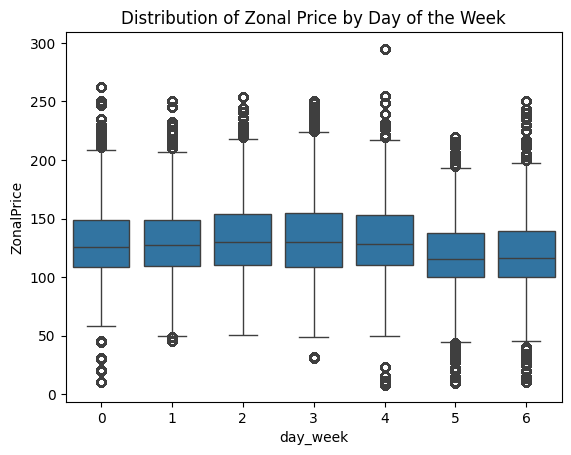

In [20]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='ZonalPrice', data=ask_df)
plt.title('Distribution of Zonal Price by Day of the Week')
plt.show()

## BID:  AGGREGATING AND TAKING MEAN

In [11]:
bid_df.set_index('Date', inplace=True)
zonal_price_means = bid_df.groupby(by=[bid_df.index]).agg({'ZonalPrice': 'mean'}).rename(columns={'ZonalPrice': 'MeanZonalPrice'}).reset_index()

In [12]:
# Extract hours and days of the week
zonal_price_means['hour'] = zonal_price_means['Date'].dt.hour
zonal_price_means['day_week'] = zonal_price_means['Date'].dt.dayofweek

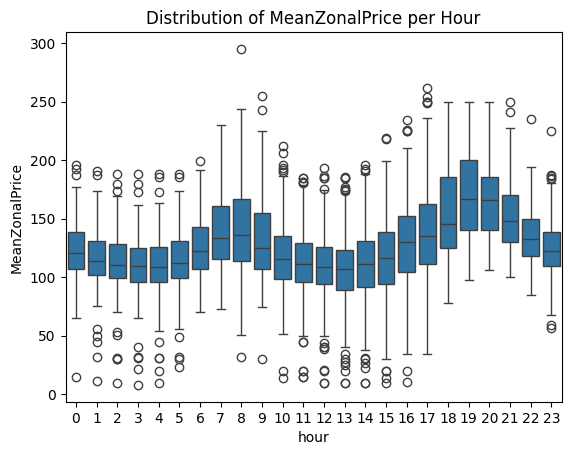

In [13]:
# Analysis for hours
sns.boxplot(x='hour', y='MeanZonalPrice', data=zonal_price_means)
plt.title('Distribution of MeanZonalPrice per Hour')
plt.show()

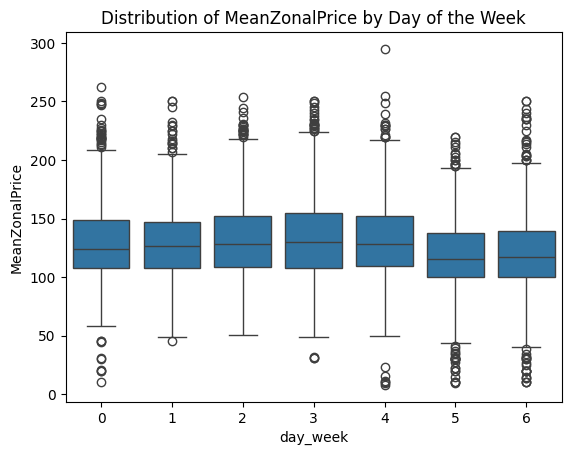

In [14]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='MeanZonalPrice', data=zonal_price_means)
plt.title('Distribution of MeanZonalPrice by Day of the Week')
plt.show()

In [95]:
# Extract day from 'Date' to use it as a part of pivot
zonal_price_means['Day'] = zonal_price_means['Date'].dt.date

# Pivot the DataFrame to get days as columns and hours as rows
pivot_df = zonal_price_means.pivot(index='hour', columns='Day', values='MeanZonalPrice')

In [96]:
date_columns = pd.to_datetime(pivot_df.columns)  # Direct conversion of all column headers
date_nums = np.array([d.toordinal() for d in date_columns])
original_prices_df = pivot_df.copy() # for plotting


In [97]:
# Prepare data for GP
X, y = [], []

subset_df = pivot_df.iloc[:, :30] ################## YOU CAN CHYANGE THIS - THIS IS WHAT WE WILL LEANT
for col_idx, col in enumerate(subset_df.columns):  # Using all columns directly
    for row_idx, price in enumerate(subset_df[col]):
        if not np.isnan(price):
            X.append([date_nums[col_idx], row_idx])  # Day and hour indices as features
            y.append(price)

X = np.array(X)
y = np.array(y)

# Define and fit the GP model
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=.5)
#kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1) + DotProduct() + RationalQuadratic()
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1)

#gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0) ############# if you want to run it on the whole dataset,chanbge the n_restarts_optimizer to 10 ish 
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=10, random_state=0)

gp.fit(X, y)

# Predict and fill in the missing values for the entire DataFrame
for col_idx, col in enumerate(pivot_df.columns):
    for row_idx in range(pivot_df.shape[0]):
        if np.isnan(pivot_df.at[row_idx, col]):
            predicted_price, _ = gp.predict([[date_nums[col_idx], row_idx]], return_std=True)
            pivot_df.at[row_idx, col] = predicted_price[0]

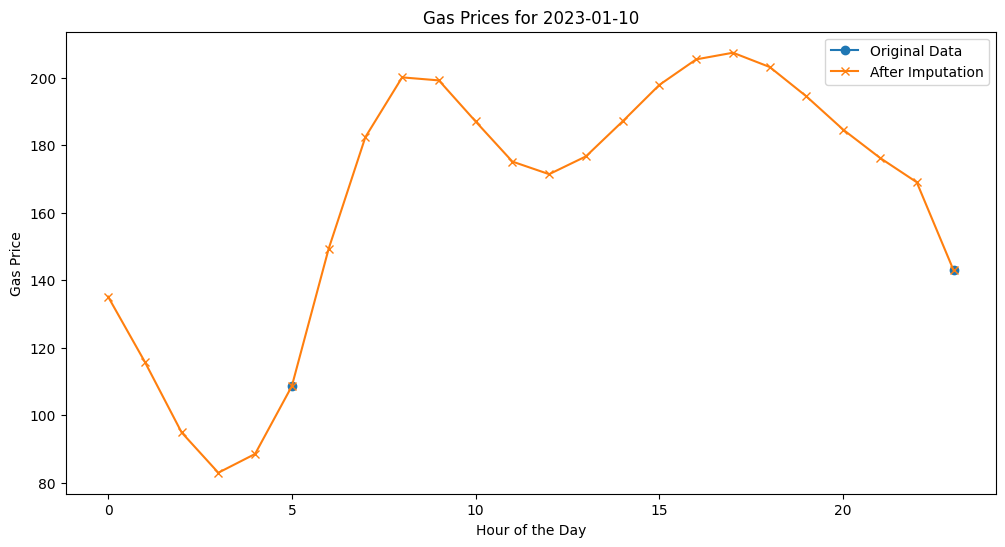

In [98]:
original_prices_df.columns  = original_prices_df.columns.astype(str)
pivot_df.columns = pivot_df.columns.astype(str)

# Example day for visualization
day_to_visualize = '2023-01-10'

# Original data might need to be stored separately before imputation to compare
original_data = original_prices_df[day_to_visualize]
imputed_data = pivot_df[day_to_visualize]

plt.figure(figsize=(12, 6))
plt.plot(original_data, 'o-', label='Original Data')
plt.plot(imputed_data, 'x-', label='After Imputation')
plt.title(f'Gas Prices for {day_to_visualize}')
plt.xlabel('Hour of the Day')
plt.ylabel('Gas Price')
plt.legend()
plt.show()

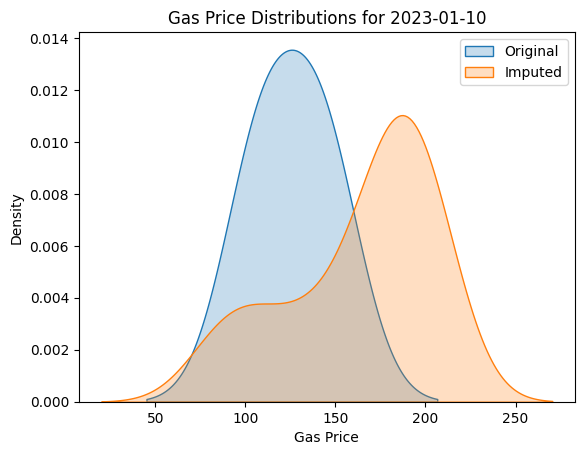

In [99]:

# Plotting distributions for Day_1 before and after imputation
sns.kdeplot(original_prices_df[day_to_visualize].dropna(), label='Original', fill=True)
sns.kdeplot(pivot_df[day_to_visualize], label='Imputed' , fill=True)
plt.xlabel('Gas Price')
plt.ylabel('Density')
plt.title(f'Gas Price Distributions for {day_to_visualize}')
plt.legend()
plt.show()

In [100]:
pivot_df[day_to_visualize]

hour
0     135.146843
1     115.815909
2      94.894591
3      82.931086
4      88.492812
5     108.604820
6     149.272920
7     182.432531
8     200.148958
9     199.254651
10    187.074187
11    175.181096
12    171.446457
13    176.722335
14    187.128452
15    197.932393
16    205.487046
17    207.459476
18    203.223342
19    194.495042
20    184.643697
21    176.283619
22    169.061999
23    143.000000
Name: 2023-01-10, dtype: float64

In [101]:
pivot_df

Day,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
hour,,,,,,,,,,,,,,,,,,,,,
0,195.90,187.270000,170.77000,121.50000,150.98,173.13,176.660000,164.87000,164.670000,135.146843,...,0.00,102.00,106.06000,106.25,107.40,111.05,100.00,112.52,105.78000,109.12000
1,191.09,187.200000,148.89000,119.22000,123.00,170.77,174.010000,155.73000,150.000000,115.815909,...,0.00,0.00,105.00000,104.22,105.93,109.02,88.50,109.62,104.73000,107.06000
2,187.95,180.000000,120.00000,100.00000,107.00,160.00,174.010000,150.00000,111.000000,94.894591,...,0.00,0.00,100.00000,103.00,103.00,107.43,84.24,108.00,100.00000,105.45000
3,187.82,180.000000,115.00000,123.87000,100.00,150.00,173.050000,150.00000,85.000000,82.931086,...,0.00,0.00,95.49982,102.66,100.00,107.43,80.00,108.00,93.65000,100.00000
4,187.74,185.890000,113.63385,128.00000,107.40,152.10,173.030000,152.63000,73.710000,88.492812,...,0.00,0.00,99.00000,101.24,100.00,108.44,83.01,108.00,95.00000,95.00000
5,187.74,185.890000,148.89000,135.00000,137.40,155.00,174.010000,154.21000,111.000000,108.604820,...,0.00,0.00,104.19000,104.19,104.19,113.02,88.96,110.54,103.99477,104.00000
6,187.22,198.850000,191.58000,171.58000,188.16,172.80,179.550000,165.00000,140.546770,149.272920,...,101.53,104.00,105.00000,107.15,105.31,137.39,0.00,110.65,106.93000,106.94000
7,187.82,202.720000,191.63000,190.00000,200.35,174.60,186.670000,170.50000,185.780000,182.432531,...,120.46,107.00,105.00000,110.00,107.01,148.50,0.00,120.00,108.62000,107.94000
8,186.47,213.360000,199.74000,217.72000,227.00,174.34,192.820000,170.50000,195.000000,200.148958,...,135.00,109.78,107.40000,114.07,110.00,157.38,0.00,132.02,111.39000,108.96000


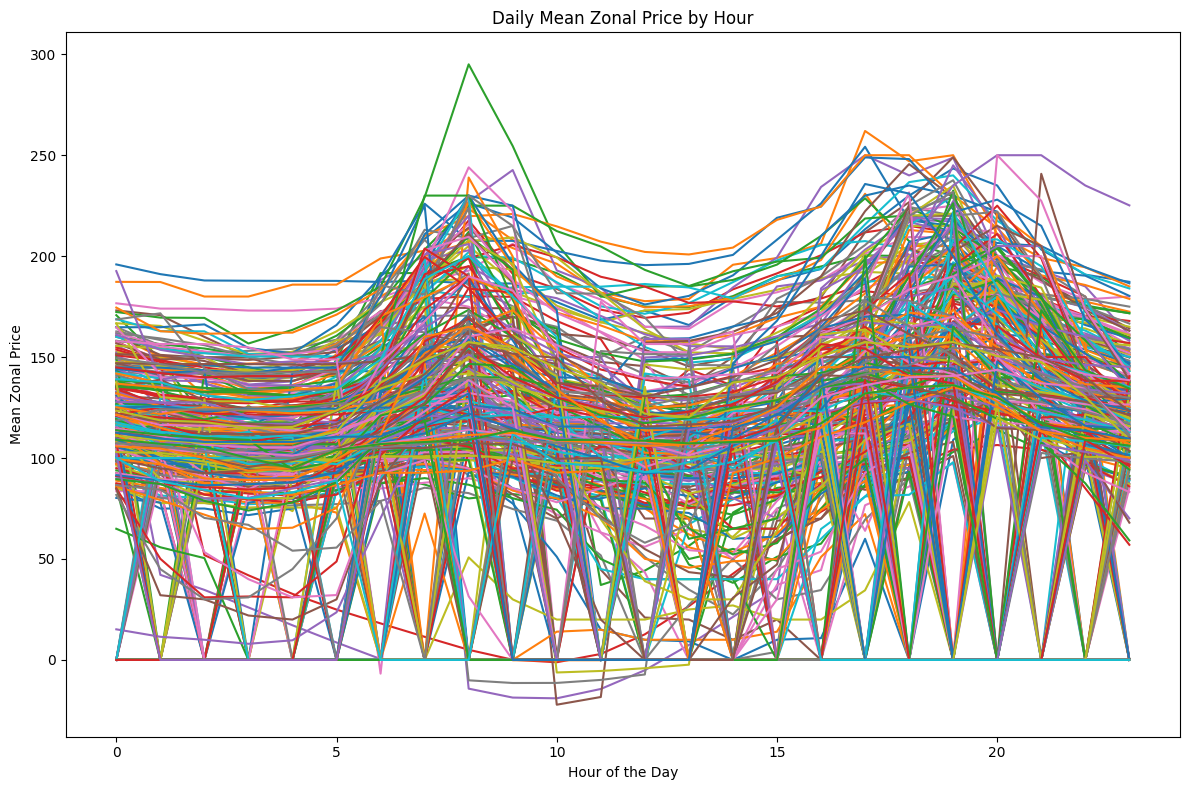

In [102]:
########### Extract day from 'Date' to use it as a part of pivot
#zonal_price_means['Day'] = zonal_price_means['Date'].dt.date

######## Pivot the DataFrame to get days as columns and hours as rows
#pivot_df = zonal_price_means.pivot(index='hour', columns='Day', values='MeanZonalPrice')
#pivot_df.ffill(axis=1, inplace=True) #### I AM FILLING MY DATA IN based on previous day's same hour value


# Plotting
plt.figure(figsize=(12, 8))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

plt.title('Daily Mean Zonal Price by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Zonal Price')
#plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

## SMOOTHEN

In [34]:
x = np.arange(24)  # Hours

POLYNOMIAL

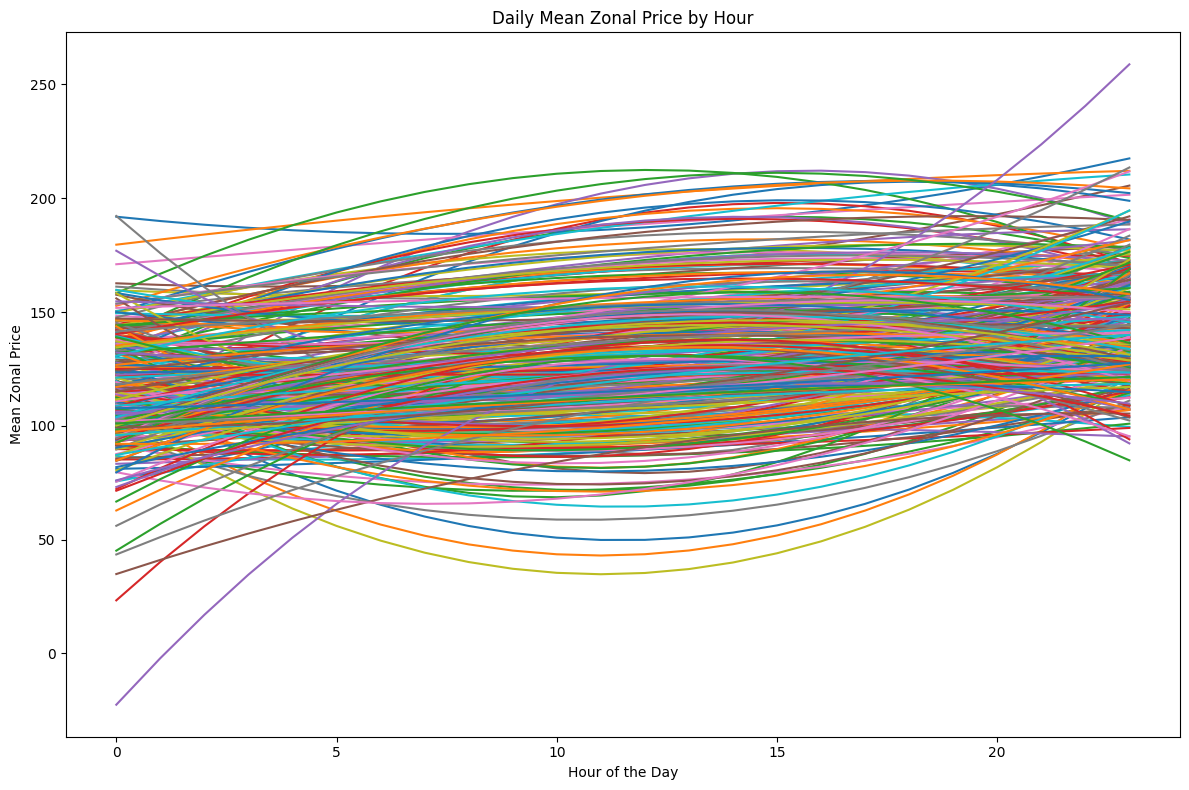

In [35]:
# Smoothing to each day's data
smoothed_data = pivot_df.apply(smooth_series, axis=0)

# Plotting
plt.figure(figsize=(12, 8))

for column in smoothed_data.columns:
    plt.plot(smoothed_data.index, smoothed_data[column], label=column)

plt.title('Daily Mean Zonal Price by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Zonal Price')
#plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout
plt.tight_layout()

plt.show()

LOESS

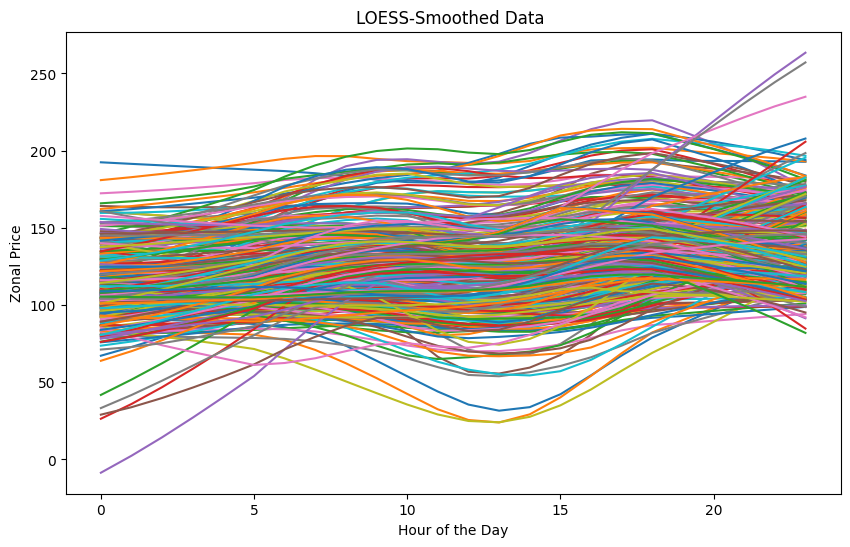

In [36]:
smoothed_df = pivot_df.apply(apply_loess, frac=0.5)  # Adjust frac as needed

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(smoothed_df.index, smoothed_df, label='Smoothed with LOESS')
plt.title(f"LOESS-Smoothed Data ")
plt.xlabel('Hour of the Day')
plt.ylabel('Zonal Price')
plt.show()

## FPCA